In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Read data

In [11]:
%cd /content/drive/'My Drive'/CNM

/content/drive/My Drive/CNM


In [12]:
df = pd.read_csv("./data/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


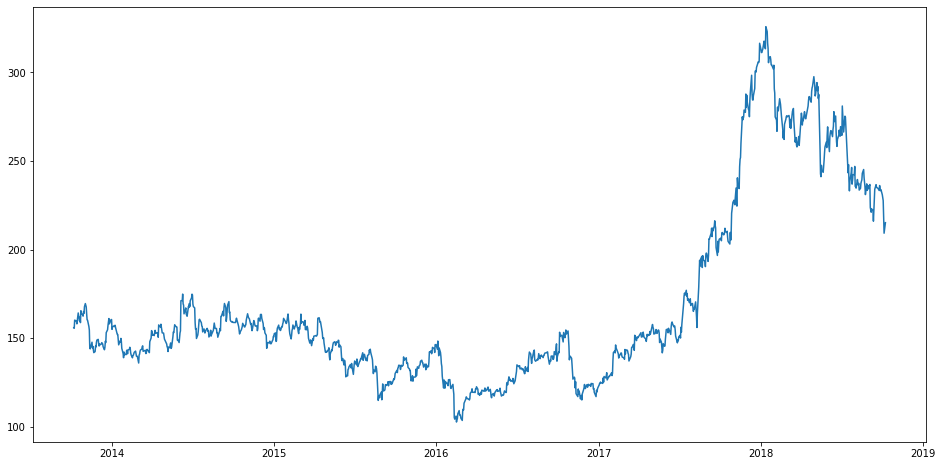

In [13]:
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize = (16,8))
plt.plot(df["Close"], label = 'Close Price history')

In [14]:
data = df.sort_index(ascending = True, axis=0)
# Use only Close as attribute
new_dataset = pd.DataFrame(index = range(0, len(df)), columns = ['Date', 'Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]

new_dataset.head()

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


In [15]:
new_dataset.shape

(1235, 2)

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))

# Erase Date column
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis = 1, inplace = True)

# Get Close column values
final_dataset = new_dataset.values
train_data = final_dataset[0: 987,:] # To train
valid_data = final_dataset[987:, :] # To test

scaler = MinMaxScaler(feature_range = (0,1)) # Scale
scaled_data = scaler.fit_transform(final_dataset) # Activate the scale

x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i - 60: i, 0]) 
    y_train_data.append(scaled_data[i, 0])
    
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

(x, y): 

In [17]:
x_train_data.shape

(927, 60, 1)

In [18]:
y_train_data.shape

(927,)

In [19]:
NUM_EPOCHS = 10

# LSTM

x -> lstm_model -> y'. Compare y with y'

(1, 2, 3) - 4
(1, 2, 3) -> lstm_model -> 5. Compare 5 with 4 using a function -> error

In [20]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
# z = ax + by

lstm_model.compile(loss='mean_squared_error', # compute error
                   optimizer='adam') # update a, b
lstm_model.fit(x_train_data, y_train_data,
               epochs=NUM_EPOCHS, # running time
               batch_size=1, # size of x
               verbose=2) # print process

Epoch 1/10
927/927 - 30s - loss: 9.9319e-04
Epoch 2/10
927/927 - 5s - loss: 5.0093e-04
Epoch 3/10
927/927 - 5s - loss: 3.8360e-04
Epoch 4/10
927/927 - 5s - loss: 3.1241e-04
Epoch 5/10
927/927 - 5s - loss: 2.6513e-04
Epoch 6/10
927/927 - 5s - loss: 2.5279e-04
Epoch 7/10
927/927 - 5s - loss: 2.4366e-04
Epoch 8/10
927/927 - 5s - loss: 2.2563e-04
Epoch 9/10
927/927 - 5s - loss: 2.5589e-04
Epoch 10/10
927/927 - 5s - loss: 2.3310e-04


loss = error

In [21]:
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60: ].values
print(inputs_data.shape)
inputs_data = inputs_data.reshape(-1, 1)
print(inputs_data.shape)
inputs_data = scaler.transform(inputs_data)

X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i - 60 : i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price) 

(308, 1)
(308, 1)


In [22]:
inputs_data.shape

(308, 1)

In [23]:
X_test.shape

(248, 60, 1)

In [24]:
predicted_closing_price.shape

(248, 1)

In [25]:
lstm_model.save("./model/lstm_model.h5") # save a, b to file
# You can load a, b for next use

MSE: 39.974600914723034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


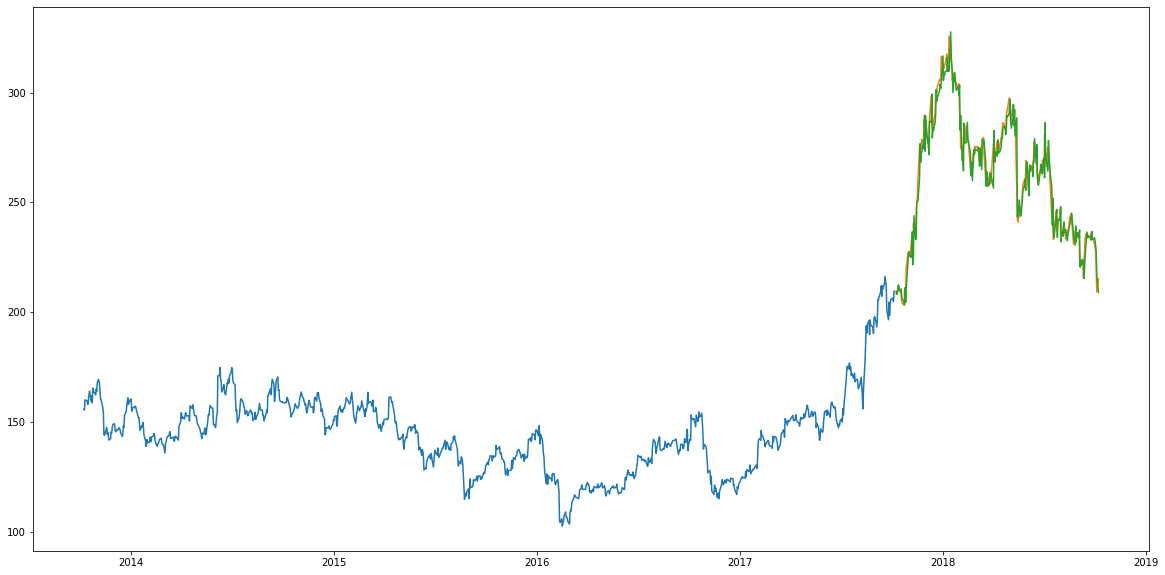

In [26]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions'] = predicted_closing_price
print('MSE: {}'.format(mean_squared_error(valid_data['Close'].values, predicted_closing_price)))

# Green is y_hat
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close', "Predictions"]])

orange: y' predicted by lstm_model  
green: true y  
The close y' to y, the better the lstm_model

In [27]:
lstm_model.evaluate(x_train_data, y_train_data)

29/29 [==============================] - 1s 5ms/step - loss: 1.5591e-04


0.00015590684779454023

# RNN

In [28]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units = 50, return_sequences = True,
                    input_shape = (x_train_data.shape[1], 1)))
rnn_model.add(SimpleRNN(units = 50))
rnn_model.add(Dense(1))

In [29]:
rnn_model.compile(loss = 'mean_squared_error', 
                   optimizer = 'adam')

rnn_model.fit(x_train_data, y_train_data,
               epochs = NUM_EPOCHS,
               batch_size = 1,
               verbose = 2)

Epoch 1/10
927/927 - 66s - loss: 0.0027
Epoch 2/10
927/927 - 58s - loss: 7.0628e-04
Epoch 3/10
927/927 - 58s - loss: 4.9196e-04
Epoch 4/10


KeyboardInterrupt: ignored

In [ ]:
predicted_closing_price = rnn_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)
print('MSE: {}'.format(mean_squared_error(valid_data['Close'].values, predicted_closing_price)))

In [ ]:
train_data = new_dataset[: 987]
valid_data = new_dataset[987: ]
valid_data['Predictions'] = predicted_closing_price

plt.plot(train_data["Close"])
plt.plot(valid_data[['Close', "Predictions"]])

In [ ]:
rnn_model.save("./model/rnn_model.h5")

In [ ]:
rnn_model.evaluate(x_train_data, y_train_data)

# XGBoost

In [30]:
!pip install -q xgboost

In [31]:
from xgboost import XGBRegressor

In [32]:
x_train_data.shape

(927, 60, 1)

In [33]:
x_train_data = np.squeeze(x_train_data, 2)
x_train_data.shape

(927, 60)

In [34]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [103]
}

eval_set = [(x_train_data, y_train_data)]
xgboost_model = XGBRegressor(objective='reg:squarederror',
                             verbose=False)
clf = GridSearchCV(xgboost_model, parameters)

clf.fit(x_train_data, y_train_data)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 300, 'random_state': 103}
Best validation score = 0.8232112665009883


In [35]:
import time

start = time.time()
params = {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 300, 'random_state': 103}
#xgboost_model = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
xgboost_model = XGBRegressor(**params, objective='reg:squarederror')
xgboost_model.fit(x_train_data, y_train_data, verbose=True)
end = time.time()

print('Took: {}s'.format(end - start))

Took: 4.545022964477539s


In [36]:
y_hat = xgboost_model.predict(x_train_data)
mean_squared_error(y_train_data, y_hat)

7.231777602425375e-05

In [37]:
X_test = np.squeeze(X_test, 2)

In [38]:
predicted_closing_price = xgboost_model.predict(X_test)
predicted_closing_price = np.expand_dims(predicted_closing_price, 1)

predicted_closing_price = scaler.inverse_transform(predicted_closing_price)
print('MSE: {}'.format(mean_squared_error(valid_data['Close'].values, predicted_closing_price)))

MSE: 3909.6175029250803


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


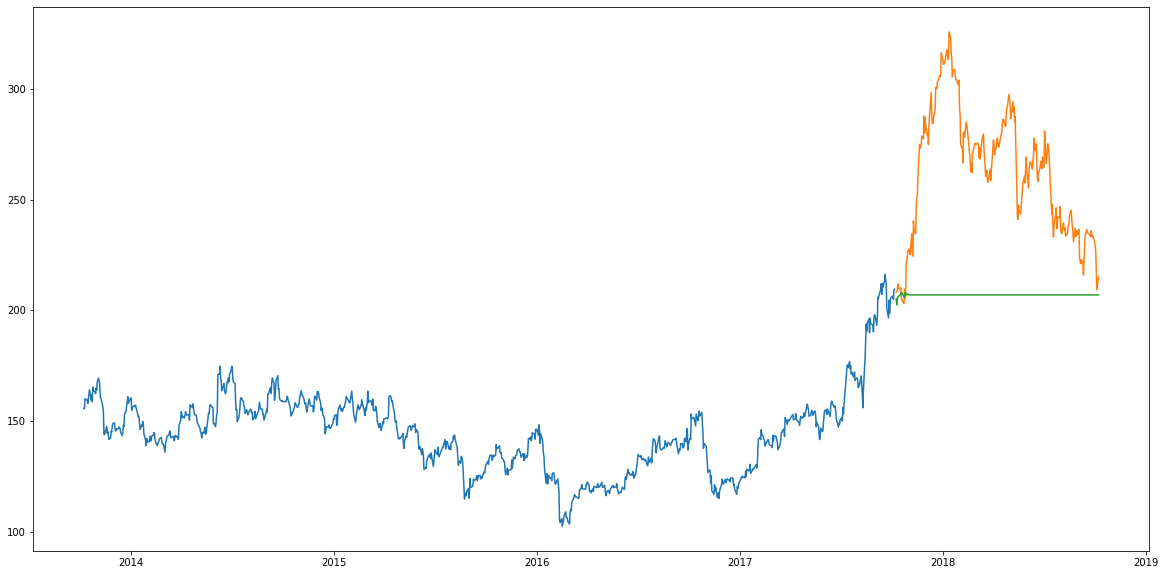

In [39]:
train_data = new_dataset[: 987]
valid_data = new_dataset[987: ]
valid_data['Predictions'] = predicted_closing_price

plt.plot(train_data["Close"])
plt.plot(valid_data[['Close', "Predictions"]])

In [40]:
xgboost_model.save_model('./model/xgboost_model.h5')

# Price Rate of Change (ROC)

In [ ]:
df = pd.read_csv("./data/NSE-Tata-Global-Beverages-Limited.csv")

df['ROC'] = ((df['Close'] - df['Close'].shift(60)) / df['Close'].shift(60)) * 100
df['ROC'].fillna(0, inplace=True)
print(df.head())

df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df['Date']

data = df.sort_index(ascending = True, axis=0)
# Use only Close as attribute
new_dataset = pd.DataFrame(index = range(0, len(df)), columns = ['Date', 'Close','ROC'])

for i in range(0,len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]
    new_dataset['ROC'][i] = data['ROC'][i]
new_dataset.head()

In [ ]:
# Combine two columns with addition
new_dataset['feature'] = new_dataset['Close'] + new_dataset['ROC']
plot_dataset = new_dataset.copy() # For plotting

new_dataset.drop('Close', axis=1, inplace=True)
new_dataset.drop('ROC', axis=1, inplace=True)

new_dataset.head()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis = 1, inplace = True)

final_dataset = new_dataset.values
train_data = final_dataset[0: 987,:]

scaler = MinMaxScaler(feature_range = (0,1)) 
scaled_data = scaler.fit_transform(final_dataset)

In [ ]:
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i - 60: i, 0]) 
    y_train_data.append(scaled_data[i, 0])
    
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

## RNN

In [ ]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units = 50, return_sequences = True,
                    input_shape = (x_train_data.shape[1], 1)))
rnn_model.add(SimpleRNN(units = 50))
rnn_model.add(Dense(1))

rnn_model.compile(loss = 'mean_squared_error', 
                   optimizer = 'adam')
rnn_model.fit(x_train_data, y_train_data,
               epochs = NUM_EPOCHS,
               batch_size = 1,
               verbose = 2)

In [ ]:
rnn_model.evaluate(x_train_data, y_train_data)

In [ ]:
plot_dataset.index = plot_dataset.Date
plot_dataset.drop("Date", axis = 1, inplace = True)
plot_dataset.drop("ROC", axis = 1, inplace = True)

inputs_data = plot_dataset[len(plot_dataset) - len(valid_data) - 60: ].values
#inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i - 60 : i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_closing_price = rnn_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [ ]:
train_data = plot_dataset[: 987]
valid_data = plot_dataset[987: ]
valid_data['Predictions'] = predicted_closing_price

plt.plot(train_data["Close"])
plt.plot(valid_data[['Close', "Predictions"]])

In [ ]:
rnn_model.save('./model/rnn_model_1.h5')

## LSTM

In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
# z = ax + by

lstm_model.compile(loss='mean_squared_error', # compute error
                   optimizer='adam') # update a, b
lstm_model.fit(x_train_data, y_train_data,
               epochs=NUM_EPOCHS, # running time
               batch_size=1, # size of x
               verbose=2) # print process

In [ ]:
lstm_model.evaluate(x_train_data, y_train_data)

In [ ]:
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

train_data = plot_dataset[: 987]
valid_data = plot_dataset[987: ]
valid_data['Predictions'] = predicted_closing_price

plt.plot(train_data["Close"])
plt.plot(valid_data[['Close', "Predictions"]])

In [ ]:
lstm_model.save('./model/lstm_model_1.h5')